In [1]:
from os import chdir
chdir("../general")
from models import *
from util import *
from observation import *
chdir("../case-studies")

from fenics import *
from mshr import *

import numpy as np
from numpy import random
from numpy import linalg as linalg
import pandas
import geopandas
import contextily as ctx

from scipy import stats
from scipy.optimize import minimize
from scipy import sparse
from scipy import linalg as dlinalg
from scipy.sparse import linalg as splinalg
from sksparse import cholmod

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from mpl_toolkits.axes_grid1 import make_axes_locatable
from decimal import Decimal

In [2]:
# Define units
distscale = 1e+03 # km in meters
timescale = 3600 # hr in seconds

# Create mesh and define function space
long_W = -129.0
long_E = -61
lat_N = 54.0
lat_S = 20.0
mesh = RectangleMesh(Point(long_W,lat_S),Point(long_E,lat_N),int(long_E-long_W),int(lat_N-lat_S))

V = FunctionSpace(mesh, 'P', 1)
fem = V.element()

interior_exp = Expression("x[0] >= -125.5 and x[0] <= -64.5 and x[1] >= 24 and x[1] <= 49.5",degree=0,domain=mesh)
interior_f = Function(V)
interior_f.interpolate(interior_exp)

class Interior(SubDomain):
	def inside(self,x,on_boundary):
		return (x[0] >= -125.5 and x[0] <= -64.5 and x[1] >= 24 and x[1] <= 49.5)
class Buffer(SubDomain):
	def inside(self,x,on_boundary):
		return (x[0] < -125.5 or x[0] > -64.5 or x[1] < 24 or x[1] > 49.5)
regions = MeshFunction("size_t", mesh, mesh.topology().dim() - 1)
subdomain_buffer = Buffer()
subdomain_buffer.mark(regions,0)
subdomain_interior = Interior()
subdomain_interior.mark(regions,1)

In [3]:
# now we need to warp the mesh to get lat/lon degrees in terms of km
x_coords = mesh.coordinates()[:,0].copy()
y_coords = mesh.coordinates()[:,1].copy()
km_y_coords = y_coords*111.11
km_x_coords = (95+x_coords)*np.cos(np.pi*y_coords/180)*111.11
km_xy_coords = np.array([km_x_coords, km_y_coords]).transpose()
mesh.coordinates()[:] = km_xy_coords

In [4]:
warped_V = FunctionSpace(mesh,'P',1)

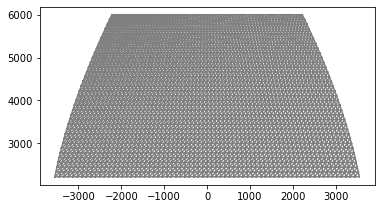

In [5]:
plot(mesh)
plt.show()

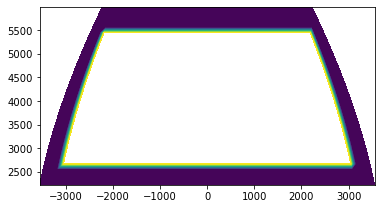

In [6]:
plot(interior_f,mesh=mesh)
plt.show()

In [7]:
chdir("../data/nomads")
wind_df = pandas.read_csv("jan01windus.csv")
chdir("../../case-studies")
lon = wind_df['lon'][wind_df['variable']=="UGRD"]
lat = wind_df['lat'][wind_df['variable']=="UGRD"]

vlon = wind_df['lon'][wind_df['variable']=="VGRD"]
vlat = wind_df['lat'][wind_df['variable']=="VGRD"]

print(np.all(np.array(vlon)==np.array(lon)))
print(np.all(np.array(vlat)==np.array(lat))) # THESE MUST BOTH BE TRUE IN ORDER FOR VEL_LAT TO BE ORDERED CORRECTLY

True
True


In [8]:
vel_lon = wind_df['value'][wind_df['variable']=="UGRD"]
vel_lat = wind_df['value'][wind_df['variable']=="VGRD"] # ARE THESE IN THE SAME ORDER SPATALLY????

# convert to km/hr and x/y projection
vel_x = (vel_lon*np.cos(lat*np.pi/180) - np.array(vel_lat*np.array((95+lon)*np.sin(lat*np.pi/180))))
vel_y = vel_lat


vel = list(zip(vel_x,vel_y))
pts = list(zip((95+lon)*np.cos(lat*np.pi/180)*111.11,lat*111.11))

vecspace = VectorFunctionSpace(mesh,'P',1,2)
vel_f = spatialvec_to_func(pts,vel,vecspace)
advection = vel_f

vel

[(-66.36984917000461, -4.92322),
 (-64.24436262513765, -4.92322),
 (-63.9490549751473, -5.04322),
 (-66.83967281877653, -5.47322),
 (-67.98800077202998, -5.79322),
 (-62.23125262994767, -5.47322),
 (-60.19913835961626, -5.52322),
 (-59.405240540926954, -5.72322),
 (-58.91114617186283, -5.93322),
 (-56.893137140135536, -5.95322),
 (-53.53121172782667, -5.84322),
 (-47.15084715932463, -5.32322),
 (-40.91897740715317, -4.73322),
 (-39.16789784803942, -4.76322),
 (-40.463570550398, -5.27322),
 (-38.32795204804261, -5.31322),
 (-34.21276255018595, -5.01322),
 (-30.54710521972903, -4.71322),
 (-27.17344372513572, -4.34322),
 (-30.456124813405104, -5.35322),
 (-33.458261568426245, -6.43322),
 (-37.46943616505308, -7.92322),
 (-36.82326741421027, -8.78322),
 (-39.971507889597596, -10.7432),
 (-3.726418489999631, -0.893215),
 (9.126401357925625, 2.99678),
 (9.40733798349521, 3.22678),
 (0.8408867828834549, -0.263215),
 (5.162823784882588, 2.85678),
 (-3.4079624753568427, -2.13322),
 (-8.4787400

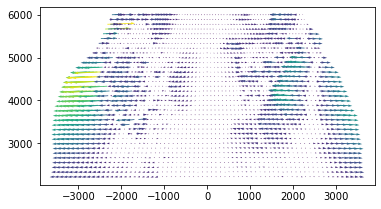

In [9]:
plot(advection,mesh=mesh)
plt.show()

In [10]:
# Get the mechanics problem matrices
u = TrialFunction(warped_V)
v = TestFunction(warped_V)
n = FacetNormal(mesh) # on external cells this automatically points out

# The mass matrix is defined by the mesh but the stiffness requires optimization for hyperparameters
mass = u*v*dx
L = assemble_mat(mass)
diag = L.sum(axis=0)
m = diag.size
print(m)
invL = sparse.spdiags(1/diag,0,m,m)

2415


In [11]:
# Get observations
chdir("../data/epa_air_quality_data")
pm25_df = pandas.read_csv("jan1_processed_air_quality_us.csv")
chdir("../../case-studies")

In [12]:
lons = pm25_df["SITE_LONGITUDE"]
lats = pm25_df["SITE_LATITUDE"]

xs = (95+lons)*np.cos(lats*np.pi/180)*111.11
ys = 111.11*lats
pts = [[xs[i],ys[i]] for i in range(len(xs))]
data = np.array(pm25_df["Daily.Mean.PM2.5.Concentration"])
O = make_obs_mat_pts(pts,fem,mesh,V,threshold=1e-10)

In [13]:
# get the posterior mean and covariance
def simultaneous_confint(cov,num_sim,p=0.05):
	std = np.sqrt(np.diag(cov))
	sim = random.multivariate_normal(np.zeros(cov.shape[0]),cov,size=num_sim)
	scaled = sim/std
	max_scaled = np.amax(scaled,axis=0)
	q = np.quantile(max_scaled,1-p)
	return q*std

def calc_hat_sigma2(x,Qpost_ch=None):

	logrho,logvarratio,logdiff,logdec = x
	rho,varratio,diff,dec = np.exp(x)
	sample_size = len(data)

	if Qpost_ch is None:
		kappa = 8*nu/rho**2
		diffusion,decay = Constant(diff),Constant(dec)
		equation = diffusion*dot(grad(u),grad(v))*dx - dot(advection*u,grad(v))*dx  + decay*u*v*dx  + dot(advection*u,n)*v*ds #- dot(n,advection)*u*v*ds # + div(advection*u)*v*dx
		K = assemble_mat(equation)
		Q_source = make_matern(guess_alpha,kappa,d,warped_V,1,threshold=0) # we are factoring out sigma2 here
		Q_prior = K.transpose().tocsc() @ invL @ Q_source @ invL @ K
		Q_post = Q_prior + O@O.transpose()/varratio	
		Qpost_ch = cholmod.cholesky(Q_post.tocsc())

	inner_prod_term1 = data@data/varratio
	inner_prod_term2 = (O@data).transpose() @ Qpost_ch.solve_A(O@data)/varratio**2
	hat_sigma2 = (inner_prod_term1 - inner_prod_term2)/sample_size
	return hat_sigma2

In [14]:
guess_alpha = 2		  # twice the number of recursive applications
d = 2				  # dimension of the space
nu = guess_alpha-d/2  # matern nu parameter

def loglik_profile(x):
	print(x)
	logrho,logvarratio,logdiff,logdec = x
	rho,varratio,diff,dec = np.exp(x)

	diffusion,decay = Constant(diff),Constant(dec)
	equation = diffusion*dot(grad(u),grad(v))*dx - dot(advection*u,grad(v))*dx  + decay*u*v*dx + dot(advection*u,n)*v*ds # + div(advection*u)*v*dx

	K = assemble_mat(equation)

	kappa = 8*nu/rho**2
	Q_source = make_matern(guess_alpha,kappa,d,warped_V,1,threshold=0) # we are factoring out sigma2 here
	Q_prior = K.transpose().tocsc() @ invL @ Q_source @ invL @ K
	Q_post = Q_prior + O@O.transpose()/varratio

	Q_prior_chol = cholmod.cholesky(Q_prior.tocsc())
	Q_post_chol = cholmod.cholesky(Q_post.tocsc())

	logsigma2hat = np.log(calc_hat_sigma2(x,Q_post_chol))

	#the quadratic form cancels out in the profile likelihood
	#quadform = np.sum(data**2)/varratio + data @ O.transpose() @ Q_post_chol(O @ data/varratio)/varratio

	logdets = len(data)*logsigma2hat + len(data)*logvarratio - Q_prior_chol.logdet() + Q_post_chol.logdet()
	loglik = np.sum(x)-logdets/2 # we need to adjust for the fact that we are transforming everything to logs
	print(-len(data)*logsigma2hat/2)
	print(-len(data)*logvarratio/2)
	print(Q_prior_chol.logdet()/2)
	print(-Q_post_chol.logdet()/2)

	print("~~~~~~~~")
	print(loglik)
	return loglik


In [15]:
minimizer = minimize(lambda x: -loglik_profile(x),np.array([0,0,0,0]),method="Nelder-Mead")
print(minimizer)

[0. 0. 0. 0.]
-2384.240048375269
-0.0
9682.721662090704
-9682.867618848733
~~~~~~~~
-2384.3860051332986
[0.00025 0.      0.      0.     ]
-2384.2395400728615
-0.0
9681.514207588409
-9681.66031020519
~~~~~~~~
-2384.3853926896436
[0.      0.00025 0.      0.     ]
-2384.1219253791355
-0.11825000000000001
9682.721662090704
-9682.86758240466
~~~~~~~~
-2384.385845693092
[0.      0.      0.00025 0.     ]
-2384.240048809213
-0.0
9682.722229168634
-9682.868185805051
~~~~~~~~
-2384.385755445631
[0.      0.      0.      0.00025]
-2384.240283794026
-0.0
9683.202563224135
-9683.34845440863
~~~~~~~~
-2384.385924978521
[0.000125 0.000125 0.000125 0.000125]
-2384.180850808395
-0.059125000000000004
9682.358665995122
-9682.504644568742
~~~~~~~~
-2384.385454382016
[ 0.0001875  0.0001875  0.0001875 -0.0001875]
-2384.1508986163662
-0.0886875
9681.45583593388
-9681.601923852733
~~~~~~~~
-2384.3852990352184
[ 0.00028125  0.00028125  0.00028125 -0.00040625]
-2384.1062056731976
-0.13303125000000002
9680.582499

-2334.6776623011533
-40.99760640052645
6242.322409865406
-6244.876074736398
~~~~~~~~
-2377.8473878972095
[ 0.6769632   0.10851129  0.27837265 -0.58342789]
-2314.8884753293587
-51.325840222587225
5369.880485824935
-5375.881509088921
~~~~~~~~
-2371.7349195658167
[ 0.89901649  0.14365686  0.37135674 -0.77564189]
-2263.5231356504446
-67.9496963545254
3997.570555882488
-4013.287261135526
~~~~~~~~
-2346.551149062139
[ 0.84496621  0.13601083  0.3456197  -0.72709843]
-2278.8503278954067
-64.33312174774639
4333.23655164907
-4345.306778642374
~~~~~~~~
-2354.6541783228877
[ 1.06323445  0.17240637  0.4309797  -0.91370695]
-2199.277065427121
-81.548214217517
2999.1241075655103
-3032.1657504255422
~~~~~~~~
-2313.1140089364876
[ 1.41247741  0.22972871  0.5704672  -1.21310235]
-1982.8193285162179
-108.66167750028255
907.1785838248975
-1031.502422160409
~~~~~~~~
-2214.8052733878158
[ 1.32626583  0.21501888  0.53986302 -1.14116842]
-2044.2124241259617
-101.70393101885449
1415.2777539549313
-1508.5719366

-1515.3788325193289
-151.2727302447581
-2320.108885462936
1841.4707055439758
~~~~~~~~
-2143.884535011935
[ 1.9725467   0.3181534   0.80569809 -1.69806008]
-1523.843571227636
-150.48655982902181
-2268.2037655444437
1797.2048243041272
~~~~~~~~
-2143.930734186825
[ 1.99039379  0.32111412  0.81278762 -1.71339644]
-1508.4999622254832
-151.88698005486748
-2362.382699711229
1877.4757492130857
~~~~~~~~
-2143.882993677491
[ 1.97278683  0.31836257  0.80536246 -1.69816243]
-1523.6056377955
-150.58549386343438
-2269.3701977756255
1798.236089524221
~~~~~~~~
-2143.926890482834
[ 1.9888465   0.32081511  0.81228073 -1.71209282]
-1509.834498828348
-151.74554486077722
-2354.2698056095132
1870.5588808121718
~~~~~~~~
-2143.881118964039
[ 1.99083361  0.32126944  0.81280156 -1.71375455]
-1508.1017431297385
-151.96044364359727
-2364.676591367313
1879.444204187264
~~~~~~~~
-2143.8834238949594
[ 1.99538433  0.32186853  0.81501166 -1.71779785]
-1504.2258344825923
-152.2438157061631
-2388.71565154164
1899.867041

-1516.0667684037574
-159.11170832061475
-2286.6415840044406
1816.873934294132
~~~~~~~~
-2143.5560230289807
[ 1.97761835  0.33752825  0.76001191 -1.68692729]
-1516.9227494611775
-159.65086419253552
-2279.095248614118
1810.7354519085618
~~~~~~~~
-2143.545179130951
[ 1.97652037  0.34351208  0.74368394 -1.68081095]
-1517.0316566366746
-162.48121425260734
-2267.9252078944123
1802.60395422191
~~~~~~~~
-2143.4512191213
[ 1.98317682  0.34262905  0.75161424 -1.68835601]
-1511.530314906264
-162.0635406321771
-2305.0241081413174
1833.8111444175988
~~~~~~~~
-2143.4177551643434
[ 1.98725988  0.34987163  0.73645218 -1.68648843]
-1507.092619375073
-165.48927936191436
-2321.018654751693
1848.9552498253681
~~~~~~~~
-2143.258208401497
[ 1.98648663  0.34902316  0.73780553 -1.68622404]
-1507.8975968836533
-165.08795453627116
-2317.3471691585123
1845.6718962895648
~~~~~~~~
-2143.2737330075465
[ 1.9804191   0.35887594  0.70742215 -1.67189424]
-1511.6597467659449
-169.74831916554365
-2275.804118131112
1812.6

-571.5594506197083
-1126.6575104617082
-3497.7712801507664
3239.118333079598
~~~~~~~~
-1956.0231525008257
[ 3.31230108  2.42833099 -3.49128126 -1.30174824]
-532.5629227030314
-1148.6005589357483
-3217.6725467423366
2972.2097001649854
~~~~~~~~
-1925.6787256410873
[ 3.28564761  2.20312598 -2.93486317 -1.46217911]
-578.4696687964147
-1042.078589110675
-3496.797323556062
3182.7201893362017
~~~~~~~~
-1933.5336608251282
[ 3.72958301  2.97740129 -4.55147173 -1.26847638]
-406.5665589798223
-1408.3108116697847
-1595.4509145684606
1484.327407244102
~~~~~~~~
-1925.1138417874681
[ 4.23039954  3.53875347 -5.57214926 -1.31083361]
-280.87202083759786
-1673.8303903209264
622.5584792414504
-665.916651832832
~~~~~~~~
-1997.1744136017164
[ 3.43351797  2.01427822 -2.32228358 -1.772898  ]
-631.7839419630117
-952.7535990008766
-3355.8918002618366
2987.0030864452474
~~~~~~~~
-1952.0736401684505
[ 3.82261194  2.64984252 -3.62961126 -1.6378206 ]
-510.2042049991133
-1253.3755105779287
-1633.8573569317182
1468.9

-489.78433438733856
-1230.3042699196137
-2462.9709127354654
2272.172554231528
~~~~~~~~
-1909.860194929453
[ 3.5419493   2.57799392 -3.68240184 -1.41089285]
-494.28089260308013
-1219.391124642794
-2541.876662592345
2344.575941527756
~~~~~~~~
-1909.946089786467
[ 3.56206202  2.60539816 -3.73589696 -1.40853313]
-488.70275628643066
-1232.3533290967302
-2460.338121824484
2270.513767173721
~~~~~~~~
-1909.8574099535854
[ 3.5637878   2.6091456  -3.74405258 -1.40719775]
-487.88514452927245
-1234.1258703884268
-2451.9143814444737
2263.04020747049
~~~~~~~~
-1909.8635058134882
[ 3.56959346  2.60674754 -3.73296642 -1.41513545]
-488.7906497769456
-1232.991585494278
-2438.6570181205057
2249.5270640541416
~~~~~~~~
-1909.883950211595
[ 3.55642874  2.60053242 -3.72813997 -1.40685053]
-489.58300423374936
-1230.0518339902308
-2480.4220537254096
2289.177523940296
~~~~~~~~
-1909.8573973424714
[ 3.55416662  2.59175605 -3.70748868 -1.41185298]
-491.58120378780103
-1225.900613728969
-2495.380366003334
2301.968

-489.10787625170525
-1231.304619860957
-2469.502607122713
2279.038251481419
~~~~~~~~
-1909.8543138245739
[ 3.56005038  2.60269428 -3.73068348 -1.40868705]
-489.2561060830251
-1231.0743928893692
-2468.4386995198583
2277.8918306018422
~~~~~~~~
-1909.8539937662222
[ 3.56041969  2.6026232  -3.73020223 -1.40910631]
-489.29502173098354
-1231.0407729955841
-2467.4973671734933
2276.955721093257
~~~~~~~~
-1909.853706461811
[ 3.55965473  2.60170979 -3.72848989 -1.40909963]
-489.4735716356313
-1230.608730977306
-2470.49642039352
2279.701250480658
~~~~~~~~
-1909.853697534854
[ 3.55950968  2.60085385 -3.72642128 -1.40965309]
-489.6742473972687
-1230.2038694370274
-2471.7404646854475
2280.7408226059206
~~~~~~~~
-1909.8534697568448
[ 3.55945415  2.60220475 -3.72995682 -1.40845174]
-489.3479044407935
-1230.8428447076176
-2470.495496270617
2279.8100226476336
~~~~~~~~
-1909.8529724360683
[ 3.55921447  2.60218924 -3.73014495 -1.40818856]
-489.34355593790605
-1230.835508712738
-2471.1166374979734
2280.420

-533.0486474579834
-1192.8446094676326
-2192.975575011921
2010.4063321527778
~~~~~~~~
-1907.297039729179
[ 3.62439233  2.50779999 -3.56147633 -1.39344217]
-538.7781406264069
-1186.1893934032091
-2192.0060709403087
2009.0562859212118
~~~~~~~~
-1906.7400452318286
[ 3.63740858  2.4760106  -3.50782407 -1.38480556]
-554.316721580749
-1171.153013794811
-2128.1430522929345
1946.4994604232656
~~~~~~~~
-1905.8925377032936
[ 3.66192696  2.46865699 -3.49146923 -1.38712524]
-562.3256645655531
-1167.6747555871552
-2029.772804772516
1852.4870228088173
~~~~~~~~
-1906.0342126398593
[ 3.66179875  2.45920474 -3.48489005 -1.37305031]
-567.4816890868061
-1163.2038417762863
-2012.95214198654
1836.955141448716
~~~~~~~~
-1905.4194682693626
[ 3.68688323  2.41898529 -3.42263048 -1.35493293]
-590.3131547666287
-1144.1800438332882
-1885.7245736704012
1714.378740176382
~~~~~~~~
-1904.5107269750467
[ 3.67641187  2.4255357  -3.43479    -1.35555281]
-585.3583648575992
-1147.278387153763
-1930.3604593661066
1757.2273

-2078.513755620144
295.9925164996277
2489.7703205101325
-2579.4269133458074
~~~~~~~~
-1867.4994927023715
[ 3.87243989  0.56448987 -0.86628955 -0.1558084 ]
-1491.7287992030595
-267.0037096063274
779.2809146250362
-891.4162721073797
~~~~~~~~
-1867.453034484201
[ 3.89785231  0.86595732 -1.22403481 -0.42088071]
-1343.7455767727708
-409.59781430307595
419.37377368246086
-539.6006381164103
~~~~~~~~
-1870.451361389448
[ 3.80321658 -0.24596091  0.24387442  0.37293404]
-1872.4680320892905
116.33950857650062
1512.7253250333024
-1623.5882072188972
~~~~~~~~
-1862.8173415557676
[ 3.76247212 -0.72035825  0.93051423  0.63683787]
-2091.199737563606
340.7294539310249
1888.9979083769945
-2004.2067306460917
~~~~~~~~
-1861.0696399379426
[ 3.806185   -0.67456766  0.90268447  0.5647881 ]
-2067.698367361597
319.0705051441272
1927.1948002946112
-2041.0308407600774
~~~~~~~~
-1857.864812775701
[ 3.78828644 -1.26893864  1.79501276  0.8566184 ]
-2340.7719927268104
600.2079749610782
2485.866116609517
-2604.2195444

-3648.41147881424
2003.8439978045403
5182.59835223242
-5369.31682052362
~~~~~~~~
-1823.2137067294761
[ 3.84396916 -4.53566445  7.1572664   1.89740956]
-3789.9407644464527
2145.3692855755485
5592.641938185995
-5779.601145250607
~~~~~~~~
-1823.1677052632383
[ 3.8594224  -4.56817571  7.22633546  1.88871245]
-3806.3379494008122
2160.74711241219
5673.341837064061
-5859.373933594577
~~~~~~~~
-1823.216638925559
[ 3.84077214 -4.4278007   6.98419363  1.85807442]
-3738.5476020787405
2094.3497329427187
5432.909364445417
-5620.130171438178
~~~~~~~~
-1823.1634366371152
[ 3.85184931 -4.36937021  6.89376916  1.83297905]
-3713.771849483255
2066.712108122478
5398.868086400854
-5583.194926918642
~~~~~~~~
-1823.1773545681176
[ 3.84930608 -4.40931347  6.95835067  1.84683968]
-3731.5708135036116
2085.6052717386306
5438.655300690942
-5624.095177474663
~~~~~~~~
-1823.1602355958673
[ 3.85454676 -4.38783723  6.94470535  1.81338093]
-3718.885693655361
2075.4470086503175
5389.753723485004
-5577.701759789414
~~~~

-3736.9559283620524
2092.362592743428
5444.139347075392
-5630.957115601988
~~~~~~~~
-1823.1535334737507
[ 3.84975086 -4.42152866  6.98508265  1.84246226]
-3735.9764552960037
2091.383056833521
5441.729156929067
-5628.545082066966
~~~~~~~~
-1823.1535565012102
[ 3.84925174 -4.42439771  6.98881316  1.84457447]
-3737.348755612706
2092.7401153698884
5445.1385988540305
-5631.941731804121
~~~~~~~~
-1823.1535315327535
[ 3.8494344  -4.42087839  6.98373068  1.84259949]
-3735.6439599152936
2091.0754788322224
5440.094975437297
-5626.934918003888
~~~~~~~~
-1823.1535374671937
[ 3.84937244 -4.42432119  6.98884027  1.84436415]
-3737.3175170853897
2092.703921658849
5445.263213147729
-5632.06140608267
~~~~~~~~
-1823.1535326855658
[ 3.84930105 -4.42554913  6.99057332  1.84510296]
-3737.9182139105064
2093.2847389291887
5447.074155180076
-5633.853644795196
~~~~~~~~
-1823.153536403518
[ 3.84941095 -4.4228666   6.98670381  1.84359122]
-3736.60948096648
2092.0159030657223
5443.087483605046
-5629.90427709946
~~

-3736.930947669593
2092.349494624473
5443.728816184
-5630.558308178555
~~~~~~~~
-1823.1535297914197
[ 3.84926583 -4.4235193   6.98758651  1.84402878]
-3736.9059317540336
2092.3246288238
5443.649924057908
-5630.479512747559
~~~~~~~~
-1823.1535298003537
[ 3.84927241 -4.42355851  6.98765806  1.84403252]
-3736.9244070331574
2092.343175442267
5443.713376127931
-5630.5430788118065
~~~~~~~~
-1823.1535297911385
 final_simplex: (array([[ 3.84927241, -4.42355851,  6.98765806,  1.84403252],
       [ 3.84926872, -4.42357187,  6.98767272,  1.84404568],
       [ 3.84926702, -4.42357297,  6.98767124,  1.84405007],
       [ 3.8492745 , -4.42354311,  6.9876335 ,  1.84402679],
       [ 3.84927064, -4.4234938 ,  6.98755938,  1.84400256]]), array([1823.15352979, 1823.15352979, 1823.15352979, 1823.15352979,
       1823.15352979]))
           fun: 1823.1535297911385
       message: 'Optimization terminated successfully.'
          nfev: 590
           nit: 340
        status: 0
       success: True
        

In [16]:
rho,varratio,diff,dec = np.exp(minimizer.x)
sigma2 = calc_hat_sigma2(minimizer.x)
kappa = 8*nu/rho**2
print([rho,np.sqrt(varratio*sigma2),np.sqrt(sigma2),diff,dec])
-loglik_profile(minimizer.x)
-loglik_profile([ 1.17462587, -2.30781809, -3.99378926, 0.54496452])

[46.95888410025215, 5.688564670164811, 51.94768823444777, 1083.181756604627, 6.321980451969048]
[ 3.84927241 -4.42355851  6.98765806  1.84403252]
-3736.9244070331574
2092.343175442267
5443.713376127931
-5630.5430788118065
~~~~~~~~
-1823.1535297911385
[1.17462587, -2.30781809, -3.99378926, 0.54496452]
-3350.300701719197
1091.59795657
5112.622768549767
-5157.222068558791
~~~~~~~~
-2307.884062118221


2307.884062118221

In [17]:
invL.todense()[0:10,0:10]

matrix([[0.00082685, 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.0002713 , 0.        , 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.00027344, 0.        , 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.00026512, 0.        ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.0001346 ,
         0.        , 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.00027344, 0.        , 0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.0002593 , 0.        , 0.        , 0.        ],
        [0.        , 0.    

In [18]:
diffusion,decay = Constant(diff),Constant(dec)
equation = diffusion*dot(grad(u),grad(v))*dx - dot(advection*u,grad(v))*dx  + decay*u*v*dx  + dot(advection*u,n)*v*ds#- dot(n,advection)*u*v*ds # + div(advection*u)*v*dx
K = assemble_mat(equation)

In [19]:
kappa = 8*nu/rho**2
Q_source = make_matern(guess_alpha,kappa,d,warped_V,1,threshold=0) # we are factoring out sigma2 here
Q_prior = K.transpose().tocsc() @ invL @ Q_source @ invL @ K
print(Q_source[0:10,0:10].todense())
print(kappa)

[[ 19.77696377  -8.52557928 -18.74735648   0.46131972   4.37109426
    2.6648247    0.           0.           0.           0.        ]
 [ -8.52557928  23.14688458  10.4373311   -6.28871621 -26.43634208
   -1.93375196   0.45717152   4.20218658   4.9446763    0.        ]
 [-18.74735648  10.4373311   28.57209552  -0.82066201 -13.69186194
  -13.48773619   0.           0.90336253   4.24912947   2.58952831]
 [  0.46131972  -6.28871621  -0.82066201  20.83823178   8.90679412
    0.17828092  -6.0715763  -24.46439813  -1.82299205   0.        ]
 [  4.37109426 -26.43634208 -13.69186194   8.90679412  49.68012995
    8.98705412  -0.79753331 -13.21653279 -25.7335627   -1.84953232]
 [  2.6648247   -1.93375196 -13.48773619   0.17828092   8.98705412
   22.35150995   0.          -0.78557507 -12.36198282 -13.1376457 ]
 [  0.           0.45717152   0.          -6.0715763   -0.79753331
    0.          19.7493981    8.510168     0.16988221   0.        ]
 [  0.           4.20218658   0.90336253 -24.46439813 -

In [20]:
K.todense()[0:10,0:10]

matrix([[ 3.78078499e+03,  1.24929235e+03,  2.44675861e+03,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [-3.02765139e+02,  1.16181428e+04,  6.20163816e+03,
          1.48492052e+03,  5.60439927e+03,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [-1.39547188e+03,  2.71188734e+03,  1.49345150e+04,
          0.00000000e+00,  4.35422347e+03,  2.06836010e+03,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00, -2.27547894e+03,  0.00000000e+00,
          1.73923675e+03,  7.45958475e+03,  0.00000000e+00,
          1.25660678e+02,  8.07762232e+03,  0.00000000e+00,
          0.00000000e+00],
        [ 0.00000000e+00, -2.80370376e+03,  1.02196377e+03,
          4.55848423e+02,  2.88065887e+04,  5.70457598e+03,
          0.00000000e+00,  4.32553463e+03,  4.101957

In [21]:
print(assemble_mat(dot(grad(u),grad(v))*dx)[0:10,0:10].todense())
print(assemble_mat(dot(advection*u,grad(v))*dx)[0:10,0:10].todense())
print(assemble_mat(decay*u*v*dx)[0:10,0:10].todense())
print(dec)

[[ 1.81511328 -0.53239873 -1.28271455  0.          0.          0.
   0.          0.          0.          0.        ]
 [-0.53239873  3.08944554  0.46999732 -0.5362972  -2.49074693  0.
   0.          0.          0.          0.        ]
 [-1.28271455  0.46999732  3.13498116  0.         -1.05778258 -1.26448136
   0.          0.          0.          0.        ]
 [ 0.         -0.5362972   0.          3.04212764  0.46385615  0.
  -0.5400323  -2.42965428  0.          0.        ]
 [ 0.         -2.49074693 -1.05778258  0.46385615  6.14988377  0.45596755
   0.         -1.06567117 -2.45550679  0.        ]
 [ 0.          0.         -1.26448136  0.          0.45596755  3.09884965
   0.          0.         -1.04375281 -1.24658304]
 [ 0.          0.          0.         -0.5400323   0.          0.
   2.99738832  0.45757368  0.          0.        ]
 [ 0.          0.          0.         -2.42965428 -1.06567117  0.
   0.45757368  6.05660633  0.4500097   0.        ]
 [ 0.          0.          0.          0

(array([628., 228.,  50.,  14.,  12.,  11.,   0.,   0.,   1.,   2.]),
 array([-1.1 ,  8.09, 17.28, 26.47, 35.66, 44.85, 54.04, 63.23, 72.42,
        81.61, 90.8 ]),
 <BarContainer object of 10 artists>)

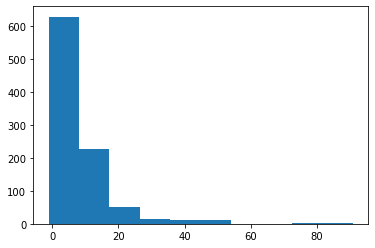

In [22]:
plt.hist(data)

In [23]:
# Now we can define these after we've optimized the parameters
diffusion,decay = Constant(diff),Constant(dec)
equation = diffusion*dot(grad(u),grad(v))*dx - dot(advection*u,grad(v))*dx  + decay*u*v*dx  + dot(advection*u,n)*v*ds#- dot(n,advection)*u*v*ds # + div(advection*u)*v*dx
K = assemble_mat(equation)

Q_source = make_matern(guess_alpha,kappa,d,warped_V,sigma2,threshold=1e-10)
sigma2_eps = varratio*sigma2

Q_prior = K.transpose() @ invL @ Q_source @ invL @ K
Q_post  = Q_prior + O @ O.transpose()/sigma2_eps


mean_soln = splinalg.spsolve(Q_post,O @ data)/sigma2_eps
mean_source = invL @ K @ mean_soln


soln_est = vec_to_func(mean_soln,warped_V)
source_est = vec_to_func(mean_source,warped_V)

cov_post = splinalg.inv(Q_post)
std_post = np.sqrt(cov_post.diagonal()) #simultaneous_confint(cov_post.todense(),1000)

cov_post_source = invL @ K @ cov_post @ K.transpose() @ invL
std_post_source = np.sqrt(cov_post_source.diagonal()) #simultaneous_confint(cov_post_source.todense(),1000)

soln_est_std = vec_to_func(std_post,warped_V)
source_est_std = vec_to_func(std_post_source,warped_V)

In [24]:
print("Amount entering:")
print(assemble(source_est*dx)) 
print("Amount leaving/decay:")
print(dec*assemble(soln_est*dx)) 

Amount entering:
703305929.2566789
Amount leaving/decay:
702377161.0779246


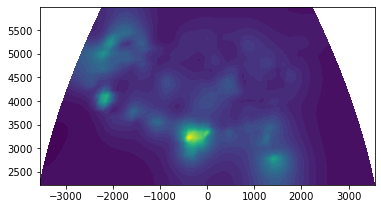

In [25]:
plot(source_est)
plt.show()

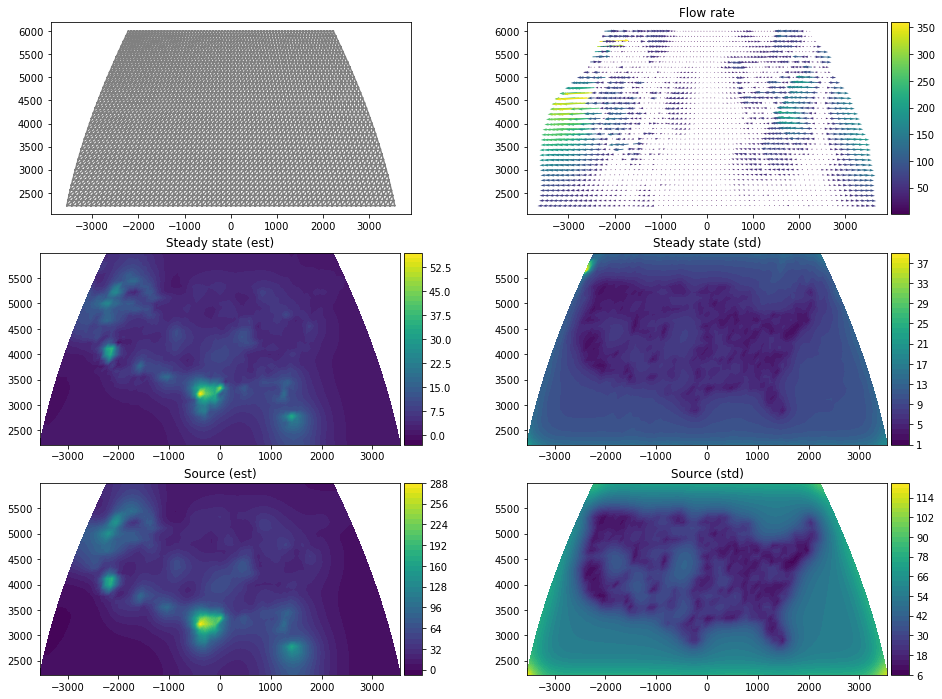

In [26]:
plt.figure(figsize=(16,12))

ax=plt.subplot(3,2,1)
c = plot(mesh)

ax=plt.subplot(3,2,2)
c = plot(advection,mesh=mesh,title="Flow rate")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
plt.colorbar(c,cax=cax)

ax=plt.subplot(3,2,3)
c = plot(soln_est,title='Steady state (est)')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
plt.colorbar(c,cax=cax)

ax=plt.subplot(3,2,4)
c = plot(soln_est_std,title='Steady state (std)')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
plt.colorbar(c,cax=cax)

ax=plt.subplot(3,2,5)
c = plot(source_est,title='Source (est)')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
plt.colorbar(c,cax=cax)

ax=plt.subplot(3,2,6)
c = plot(source_est_std,title='Source (std)')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
plt.colorbar(c,cax=cax)

plt.show()

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


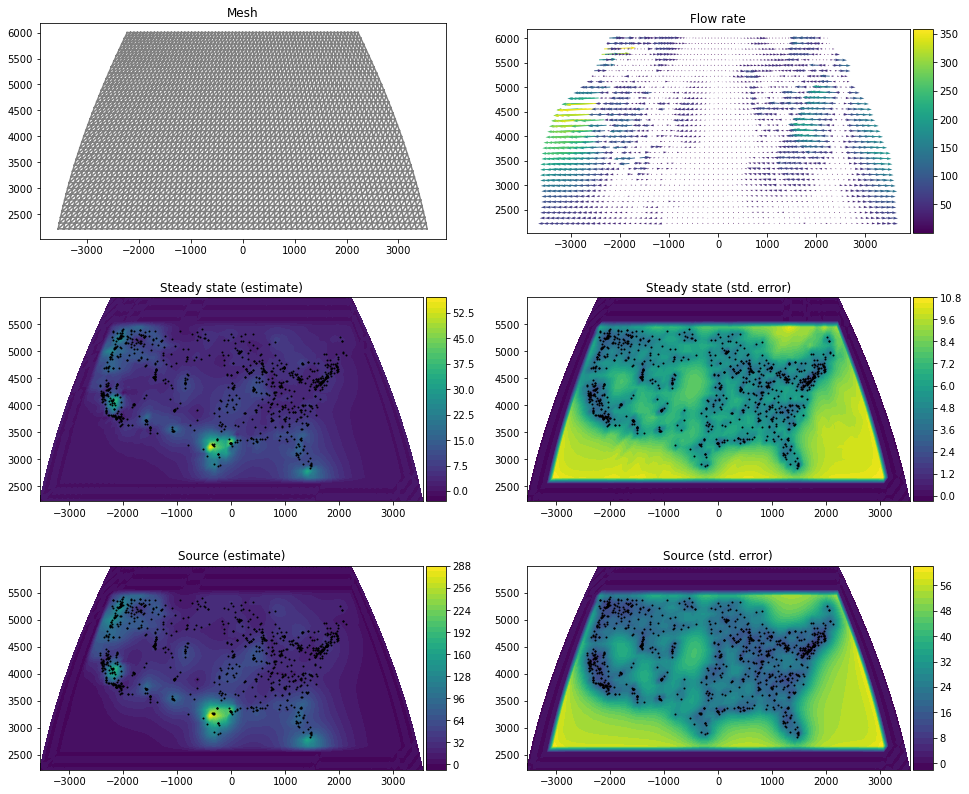

In [27]:
plt.figure(figsize=(16,14))

ax=plt.subplot(3,2,1)
c = plot(mesh,title="Mesh")

ax=plt.subplot(3,2,2)
c = plot(advection,mesh=mesh,title="Flow rate")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
plt.colorbar(c,cax=cax)

ax=plt.subplot(3,2,3)
c = plot(soln_est*interior_f,title='Steady state (estimate)')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
plt.colorbar(c,cax=cax)
ax.scatter(xs,ys,s=1,color="black")

ax=plt.subplot(3,2,4)
c = plot(soln_est_std*interior_f,title='Steady state (std. error)')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
plt.colorbar(c,cax=cax)
ax.scatter(xs,ys,s=1,color="black")

ax=plt.subplot(3,2,5)
c = plot(source_est*interior_f,title='Source (estimate)')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
plt.colorbar(c,cax=cax)
ax.scatter(xs,ys,s=1,color="black")


ax=plt.subplot(3,2,6)
c = plot(source_est_std*interior_f,title='Source (std. error)')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
plt.colorbar(c,cax=cax)
ax.scatter(xs,ys,s=1,color="black")

plt.show()

Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.
Object cannot be plotted directly, projecting to piecewise linears.


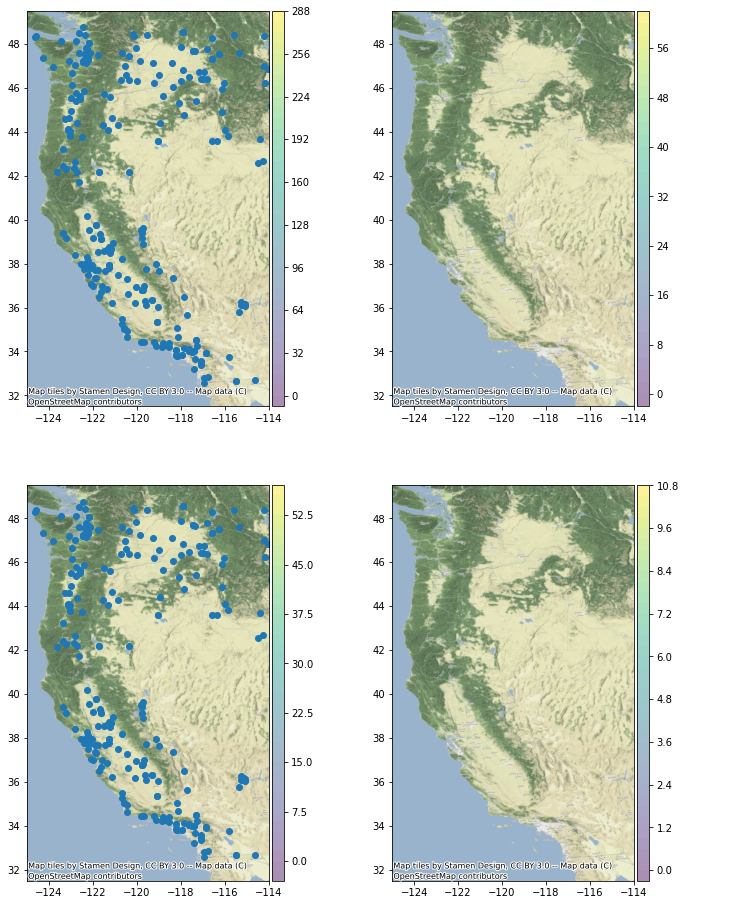

In [28]:
plt.figure(figsize=(12,16))

ax = plt.subplot(2,2,1)
ax.set_xlim([-125,-114])
ax.set_ylim([31.5,49.5])
c = plot(source_est*interior_f,alpha=0.45)
ax.scatter(lons,lats)
ctx.add_basemap(ax,zoom=8,crs="EPSG:4326")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
plt.colorbar(c,cax=cax)

ax = plt.subplot(2,2,2)
ax.set_xlim([-125,-114])
ax.set_ylim([31.5,49.5])
c = plot(source_est_std*interior_f,alpha=0.45)
ctx.add_basemap(ax,zoom=8,crs="EPSG:4326")
ax.scatter(xs,ys)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
plt.colorbar(c,cax=cax)

ax = plt.subplot(2,2,3)
ax.set_xlim([-125,-114])
ax.set_ylim([31.5,49.5])
c = plot(soln_est*interior_f,alpha=0.45)
ax.scatter(lons,lats)
ctx.add_basemap(ax,zoom=8,crs="EPSG:4326")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
plt.colorbar(c,cax=cax)

ax = plt.subplot(2,2,4)
ax.set_xlim([-125,-114])
ax.set_ylim([31.5,49.5])
c = plot(soln_est_std*interior_f,alpha=0.45)
ctx.add_basemap(ax,zoom=8,crs="EPSG:4326")
ax.scatter(xs,ys)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right",size="5%",pad=0.05)
plt.colorbar(c,cax=cax)
plt.show()